In [47]:
import numpy as np
import mindspore
import mindspore.nn as nn
from mindspore.nn.learning_rate_schedule import LearningRateSchedule
from mindspore import Tensor
import matplotlib.pyplot as plt
from scheduler import CyclicCosineDecayLR

In [48]:
def train():
    # training routines run here
    # commented out for simplicity
    
#     model.train()
#     for xb, yb in dataloader:
#         xb, yb = xb.to(device), yb.to(device)
#         optimizer.zero_grad()
#         out = model(xb)
#         loss = loss_function(out, yb)
#         loss.backward()
#         optimizer.step()
    return

def validate():
    # validation routines run here 
    # commented out for simplicity
    
#     y_pred, y_true = [], []
#     model.eval()
#     with torch.no_grad():
#         for xb, yb in dataloader:
#             xb = xb.to(device)
#             out = model(xb)
#             y_pred.append(out.detach_().cpu())
#             y_true.append(yb)
#         y_pred = torch.cat(y_pred, dim=0)
#         y_true = torch.cat(y_true, dim=0)
#     return metric_function(y_pred, y_true)
    return

In [49]:
from collections.abc import Iterable
from math import log, cos, pi, floor
from mindspore.nn.learning_rate_schedule import LearningRateSchedule
import numpy as np
import mindspore
from mindspore import Tensor

class CyclicCosineDecayLR(LearningRateSchedule):
    def __init__(self,
                 base_lr,
                 init_decay_epochs,
                 min_decay_lr,
                 total_epochs,
                 restart_interval=None,
                 restart_interval_multiplier=None,
                 restart_lr=None,
                 warmup_epochs=None,
                 warmup_start_lr=None):
        """
        初始化 CyclicCosineDecayLR 学习率调度器。

        :param base_lr: 初始学习率，float 或 float 列表。
        :param init_decay_epochs: 初始衰减阶段的 epoch 数。
        :param min_decay_lr: 衰减结束时的最小学习率，float 或 float 列表。
        :param total_epochs: 总的训练 epoch 数。
        :param restart_interval: 周期性重启的间隔。
        :param restart_interval_multiplier: 周期性重启间隔的倍率因子。
        :param restart_lr: 重启时的学习率，float 或 float 列表。如果为 None，则使用 base_lr。
        :param warmup_epochs: 预热阶段的 epoch 数。
        :param warmup_start_lr: 预热开始时的学习率，float 或 float 列表。
        """
        super(CyclicCosineDecayLR, self).__init__()
        
        # 首先确定参数组的数量
        if isinstance(base_lr, list):
            self.num_groups = len(base_lr)
        else:
            self.num_groups = 1
        
        # 将学习率参数统一为列表形式，以支持多参数组
        self.base_lrs = self._format_param(base_lr)
        self.min_decay_lrs = self._format_param(min_decay_lr)
        self.restart_lrs = self._format_param(restart_lr) if restart_lr is not None else self.base_lrs
        self.warmup_start_lrs = self._format_param(warmup_start_lr) if warmup_start_lr is not None else None

        self.init_decay_epochs = init_decay_epochs
        self.total_epochs = total_epochs
        self.restart_interval = restart_interval
        self.restart_interval_multiplier = restart_interval_multiplier
        self.warmup_epochs = warmup_epochs

        if warmup_epochs is not None and warmup_start_lr is None:
            raise ValueError("warmup_start_lr 必须在 warmup_epochs 不为 None 时设置")

        self.lrs = self.compute_lr_schedule()

    def construct(self, global_step):
        # 返回当前 step 的学习率列表
        if global_step >= len(self.lrs):
            global_step = len(self.lrs) - 1  # 防止索引越界
        lrs = [Tensor(self.lrs[global_step][i], mindspore.float32) for i in range(self.num_groups)]
        return lrs

    def compute_lr_schedule(self):
        lrs = []
        for epoch in range(self.total_epochs):
            lr_epoch = []
            for idx in range(self.num_groups):
                base_lr = self.base_lrs[idx]
                min_lr = self.min_decay_lrs[idx]
                restart_lr = self.restart_lrs[idx]
                warmup_start_lr = self.warmup_start_lrs[idx] if self.warmup_start_lrs is not None else None

                if self.warmup_epochs is not None and epoch < self.warmup_epochs:
                    # 预热阶段
                    t = epoch
                    T = self.warmup_epochs
                    lr = self._calc_lr(t, T, warmup_start_lr, base_lr)
                elif epoch < (self.warmup_epochs or 0) + self.init_decay_epochs:
                    # 初始衰减阶段
                    t = epoch - (self.warmup_epochs or 0)
                    T = self.init_decay_epochs
                    lr = self._calc_lr(t, T, base_lr, min_lr)
                else:
                    # 周期性阶段
                    if self.restart_interval is not None:
                        effective_epoch = epoch - (self.warmup_epochs or 0) - self.init_decay_epochs
                        if self.restart_interval_multiplier is None:
                            # 固定周期
                            T = self.restart_interval
                            cycle_epoch = effective_epoch % T
                            lr_start = restart_lr
                            lr_end = min_lr
                            lr = self._calc_lr(cycle_epoch, T, lr_start, lr_end)
                        else:
                            # 几何增长周期
                            n = self._get_n(effective_epoch)
                            sn_prev = self._partial_sum(n)
                            cycle_epoch = effective_epoch - sn_prev
                            T = self.restart_interval * (self.restart_interval_multiplier ** n)
                            lr_start = restart_lr
                            lr_end = min_lr
                            lr = self._calc_lr(cycle_epoch, T, lr_start, lr_end)
                    else:
                        # 无周期，保持最小学习率
                        lr = min_lr
                lr_epoch.append(lr)
            lrs.append(lr_epoch)
        return lrs

    def _calc_lr(self, t, T, lr_start, lr_end):
        # 余弦衰减公式
        cos_inner = np.pi * t / T
        cos_out = (1 + np.cos(cos_inner)) / 2
        lr = lr_end + (lr_start - lr_end) * cos_out
        return lr

    def _get_n(self, epoch):
        if self.restart_interval_multiplier == 1 or self.restart_interval_multiplier is None:
            n = int(epoch // self.restart_interval)
        else:
            numerator = 1 - (1 - self.restart_interval_multiplier) * epoch / self.restart_interval
            if numerator <= 0:
                return 0
            n = int(np.floor(np.log(numerator) / np.log(self.restart_interval_multiplier)))
        return n

    def _partial_sum(self, n):
        if self.restart_interval_multiplier == 1 or self.restart_interval_multiplier is None:
            return n * self.restart_interval
        else:
            return self.restart_interval * (1 - self.restart_interval_multiplier ** n) / (1 - self.restart_interval_multiplier)

    def _format_param(self, param):
        if isinstance(param, (float, int)):
            return [param] * self.num_groups
        elif isinstance(param, list):
            if len(param) != self.num_groups:
                raise ValueError("参数列表的长度必须等于参数组的数量")
            return param
        elif param is None:
            return [None] * self.num_groups
        else:
            raise TypeError("参数必须是 float、int 或 float 列表")


In [50]:
class TestNet(nn.Cell):
    def __init__(self):
        super(TestNet, self).__init__()
        self.fc = nn.Dense(10, 5)

    def construct(self, x):
        return self.fc(x)

In [51]:
def visualize_learning_rate(scheduler):
    lrs = scheduler.lrs
    epochs = np.arange(1, len(lrs)+1)
    plt.figure(figsize=(12,4))
    plt.plot(epochs, lrs)
    plt.title('Learning rate change')
    plt.xlabel('Epochs')
    plt.ylabel('Learning rate')
    plt.xticks(np.arange(0, len(lrs)+1, 10), rotation=45)
    plt.yticks(np.arange(0.01, 0.11, 0.01))
    plt.grid(True)
    plt.show()


In [52]:
# 实例化模型
model = TestNet()

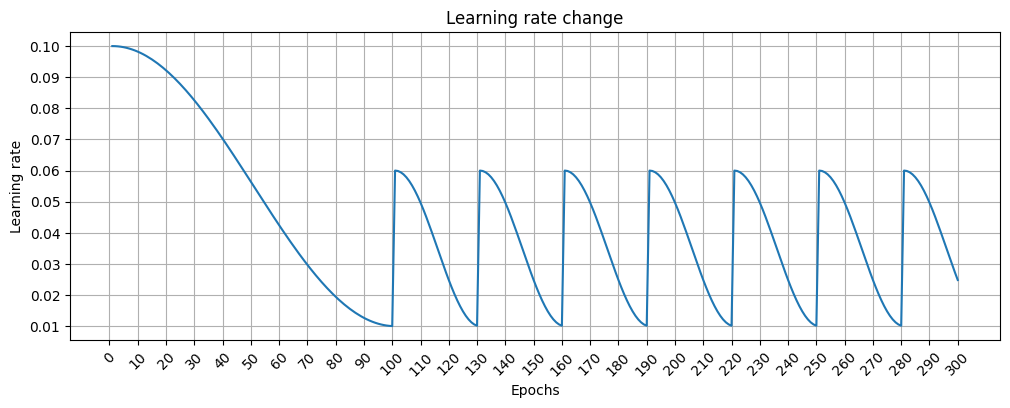

In [53]:
# 固定周期
scheduler = CyclicCosineDecayLR(
    base_lr=0.1,
    init_decay_epochs=100,
    min_decay_lr=0.01,
    total_epochs=300,
    restart_interval=30,
    restart_lr=0.06
)
visualize_learning_rate(scheduler)

### Geometrically increasing cycle intervals

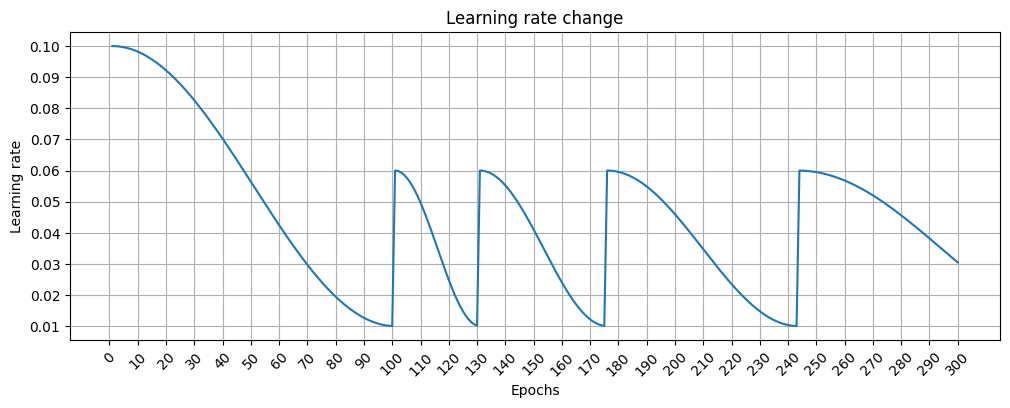

In [54]:
# 几何增长周期
scheduler = CyclicCosineDecayLR(
    base_lr=0.1,
    init_decay_epochs=100,
    min_decay_lr=0.01,
    total_epochs=300,
    restart_interval=30,
    restart_interval_multiplier=1.5,
    restart_lr=0.06
)
visualize_learning_rate(scheduler)

if `restart_lr` is omitted, learning rate is set to `lr` on each restart

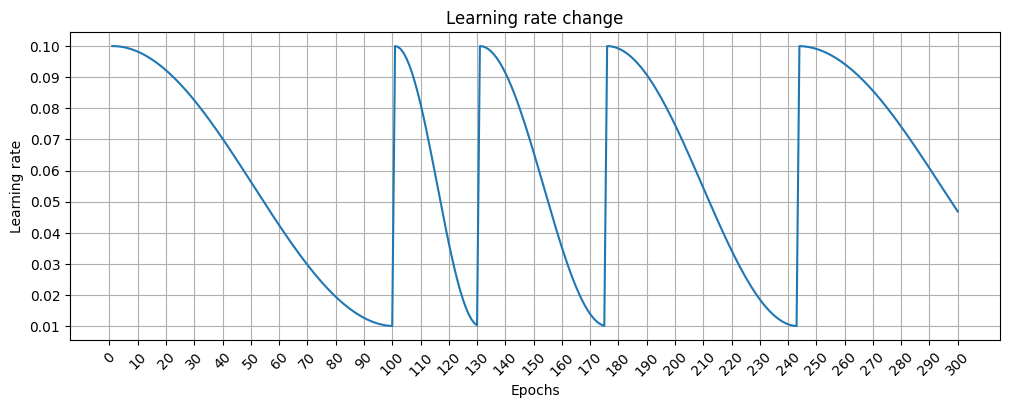

In [55]:
# 无 restart_lr，使用 base_lr
scheduler = CyclicCosineDecayLR(
    base_lr=0.1,
    init_decay_epochs=100,
    min_decay_lr=0.01,
    total_epochs=300,
    restart_interval=30,
    restart_interval_multiplier=1.5
)
visualize_learning_rate(scheduler)

### With warmup

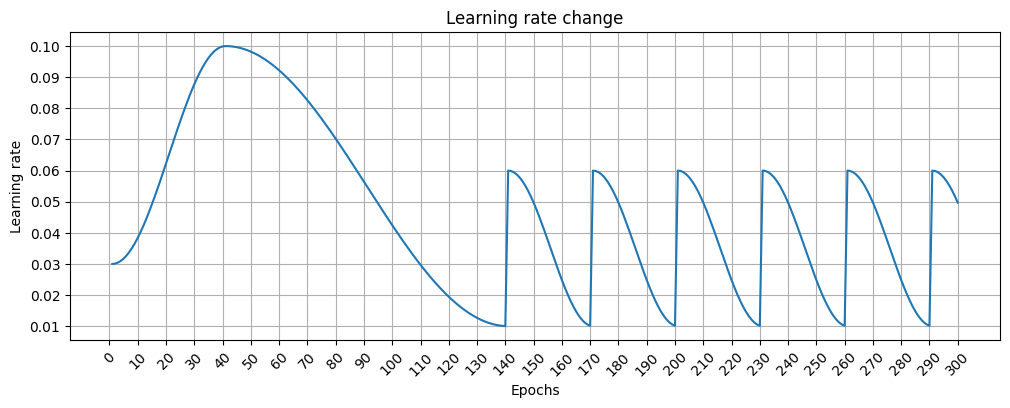

In [56]:
# 含有 warmup
scheduler = CyclicCosineDecayLR(
    base_lr=0.1,
    init_decay_epochs=100,
    min_decay_lr=0.01,
    total_epochs=300,
    restart_interval=30,
    restart_lr=0.06,
    warmup_epochs=40,
    warmup_start_lr=0.03
)
visualize_learning_rate(scheduler)

### No warmup, no cycles

Just a normal cosine annealing

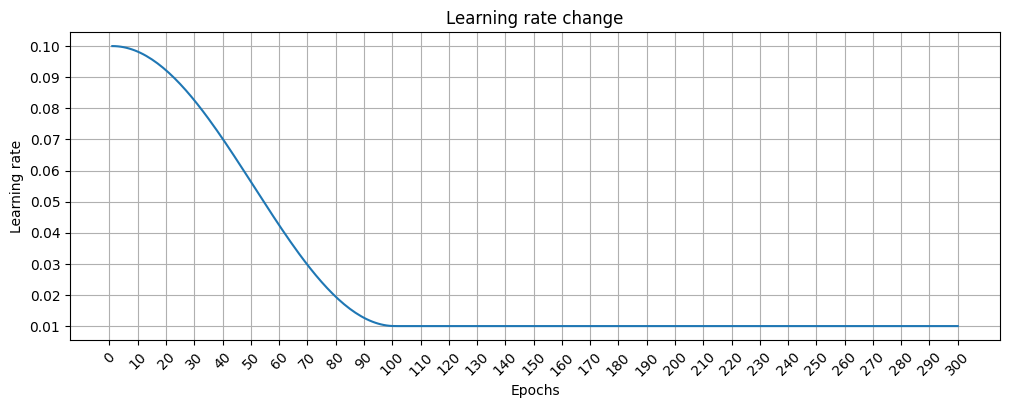

In [57]:
# 无 warmup，无周期
scheduler = CyclicCosineDecayLR(
    base_lr=0.1,
    init_decay_epochs=100,
    min_decay_lr=0.01,
    total_epochs=300
)
visualize_learning_rate(scheduler)

### Multiple parameter groups 

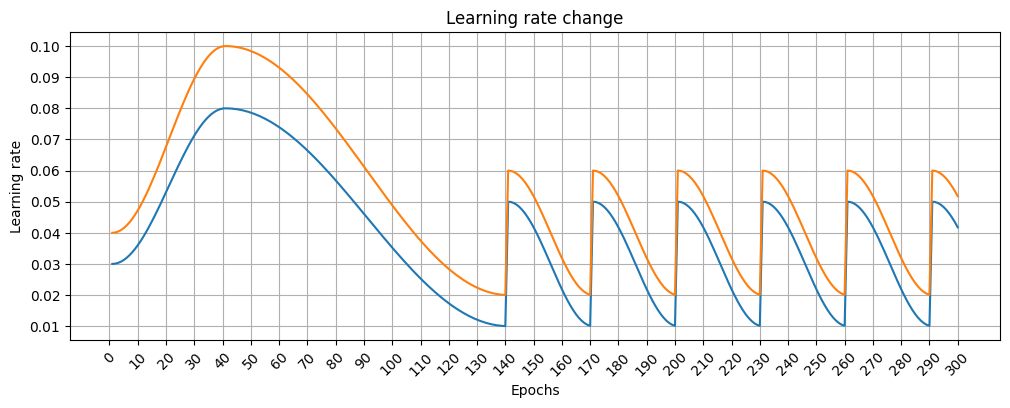

In [58]:
# 实例化模型
model1 = TestNet()
model2 = TestNet()

# 定义多个参数组，每个参数组有自己的初始学习率
params = [
    {'params': model1.get_parameters(), 'lr': 0.08},
    {'params': model2.get_parameters(), 'lr': 0.1}
]

# 定义学习率调度器，针对每个参数组设置不同的学习率参数
scheduler = CyclicCosineDecayLR(
    base_lr=[0.08, 0.1],
    init_decay_epochs=100,
    min_decay_lr=[0.01, 0.02],
    total_epochs=300,
    restart_interval=30,
    restart_lr=[0.05, 0.06],
    warmup_epochs=40,
    warmup_start_lr=[0.03, 0.04]
)

# 定义优化器，传入参数组和学习率调度器
optimizer = nn.SGD(params, learning_rate=scheduler)

# 可视化学习率变化
visualize_learning_rate(scheduler)
